# Number of fills for drugs with reject code 76

Pharmacy claims might be rejected with code 76 because a patient fills some drug to its limited number. In this notebook, we try to determine the limitation on number of fills for such drugs. 

**Assumptions.** Suppose drug X for a payer can be rejected with code 76. 
1. The number of fills  for X of all patients that filed claims for X are identically independently drew from some Possion distribution
$$P(n;\mu) = \frac{e^{-\mu} \mu^{n-1}}{(n-1)!},$$
where $\mu$ is the unknown average number of fills.
2. The limitation $L$ times of fills is the same for all patitents.
3. Total pharmacy claims approval rate for drug X with a fixed payer is known, say $N$, and the total approved claims is also known to be $M$.

The probability of a pharmacy claim getting approved is
$$P(1 \le n \le L; \mu).$$

We can estimate the probability of a pharmacy claim getting approved to be $\frac{M}{N}$, so $\mu$ and $L$ is related by
$$P(1 \le n \le L; \mu) \approx \frac{M}{N},$$
which allows us to determine $L$ from $\mu$.

**Note: The estimation between $L$ and $\mu$ relies critically on the distribution $P(n; \mu)$. So the estimation can be poor if the actual distribution of $P(n; \mu)$ is not a Possion distribution.**

In [1]:
from scipy.stats import poisson
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

import utils

## Probability of approval

In [2]:
df = utils.load_tables()['full']
df76 = df[(df.reject_code != 70) & (df.reject_code != 75)]
df76 = df76.groupby(['bin', 'drug']).agg(
    total=('pharmacy_claim_approved', 'count'),
    approved=('pharmacy_claim_approved', 'sum'),
).reset_index()
df76['rate'] = df76.approved / df76.total
df76

,bin,drug,total,approved,rate
0,417380,B,44371,39952,0.900408
1,417614,C,72140,65055,0.901788
2,417740,A,108768,97951,0.900550
3,999001,A,325532,293040,0.900188
4,999001,B,164658,148286,0.900570
5,999001,C,150550,135341,0.898977


For all drugs that rejected with code 76 for all payers in this dataset, the probability of claims being approved is about 0.9. In a mathematical form,
$$P(1 \le n \le L; \mu) \approx 0.9,$$

## $L$ as a function of $\mu$

In [3]:
def solve_L(mu, p=0.9):
    '''For a given $\mu$, find the best $L$, such that
    $P(1 \le n \le L; \mu)$ is close to p.
    '''
    
    L = 1
    loss = abs(poisson.cdf(L, mu, 1) - p)
    while loss > abs(poisson.cdf(L+1, mu, 1) - p):
        loss = abs(poisson.cdf(L+1, mu, 1) - p)
        L += 1
    return L, loss

In [4]:
# compute L for mu = 1, 2, ... 10
mu = np.arange(1, 11)
L = np.array([solve_L(a, 0.9)[0] for a in mu])

df_temp = pd.DataFrame(
    data={
        'Average number of fills': mu,
        'Limitation of fills': L
    }
)
df_temp

,Average number of fills,Limitation of fills
0,1,3
1,2,4
2,3,6
3,4,7
4,5,9
5,6,10
6,7,11
7,8,12
8,9,13
9,10,15


If the average number of fills is 4, the the estimated limitation of fills is 7 times. That is to say, a patient can fill this drug for 7 times without getting rejected with code 76.

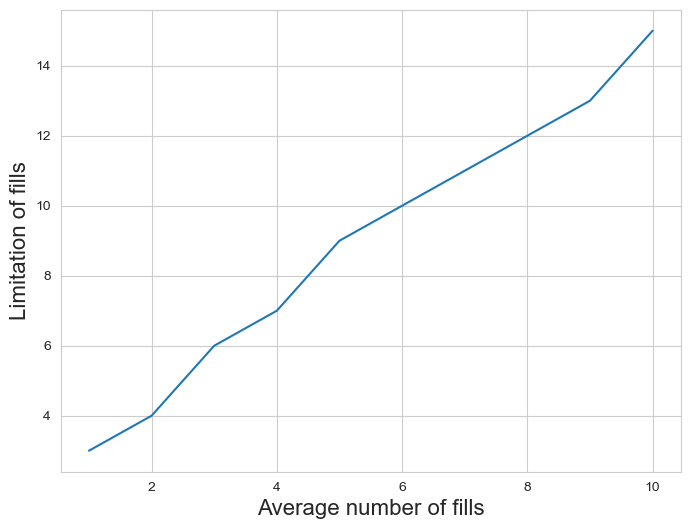

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(mu, L)
plt.xlabel('Average number of fills', fontsize=16)
plt.ylabel('Limitation of fills', fontsize=16)
plt.show()

Limitations of fills are roughly linear to average numbers of fills.

## The best $\mu$ and $L$

In our dataset, the average rate of approval for drugs associated with code 76 is 0.9. We can find the best pair ($\mu$, $L$) that minimizes
$$C(\mu, L) = \left|0.9 - P(1\le n \le L; \mu)\right|.$$

In the `solve_L` function, it not only returns the best $L$ for a given $\mu$ (and $p$), but also returns $C(\mu, L)$. To find the best pair of $(\mu, L)$, we can search a range of $\mu$s, and find the pair with smallest $C(\mu, L)$.

In [6]:
p = 0.9
search_range = np.arange(1, 11)
candidates = [(m, *solve_L(m, p)) for m in search_range]
candidates.sort(key=lambda x: x[-1])
candidates

[(7, 11, 0.0014792058890872317),
 (4, 7, 0.01067397840257367),
 (8, 12, 0.011924001018518537),
 (6, 10, 0.01607598300512414),
 (3, 6, 0.01608205796869655),
 (10, 15, 0.01654152706533718),
 (1, 3, 0.019698602928605813),
 (9, 13, 0.02422657082903512),
 (5, 9, 0.031906365278151605),
 (2, 4, 0.04287653950145298)]

In [7]:
print(
    f'The best pair of (mu, L) is {tuple(candidates[0][:2])}.'
)

The best pair of (mu, L) is (7, 11).


## Potential Application

This estimate can help payers to make strategy on the limition of fills, and thus affect the number of prior authorizations they need to process. It can applied to balance the cost between handling prior authorizations and the cost of approving a drug.

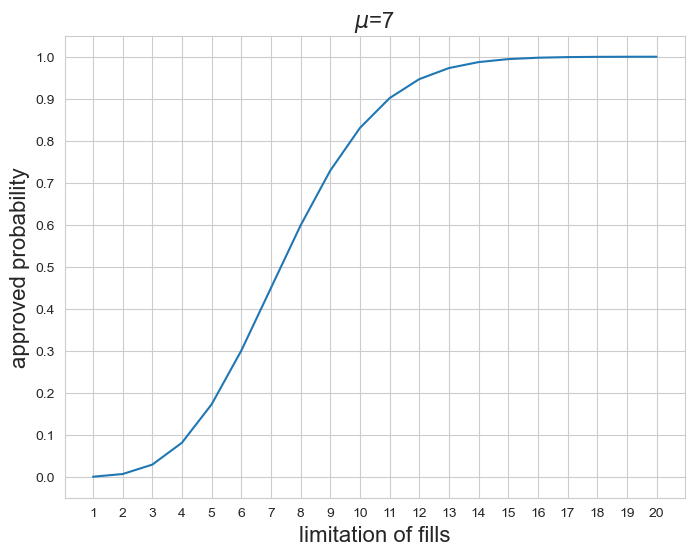

In [8]:
def approved_proba(mu, L):
    return poisson.cdf(L, mu, 1)

mu = 7
L = np.arange(1, 21)
p = [approved_proba(mu, l) for l in L]

plt.figure(figsize=(8, 6))
plt.plot(L, p, label=f'$\mu$={mu}')
plt.title(f'$\mu$={mu}', fontsize=16)
plt.xlabel('limitation of fills', fontsize=16)
plt.xticks(L, L)
plt.yticks(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1).round(1))
plt.ylabel('approved probability', fontsize=16)
plt.show()

The plot shows how the approved probability changes as limitation of fills changes, if the average number of fills is 7. We see that if the limitation of fills is 11, the approved probability is roughly 90%. It means that for 100 pharmacy claims on this drug for a payer, 10 prior authorizations will be filed to the payer. If we increase the limitation of fills to 12, then only 5 prior authorizatinos will be filed because the approved probability increases to roughly 95%. It effectively reduces half of the prior authorizations the payer needs to process.  